In [1]:
# Salma Chaaban - 301216551
# COMP257 - Assignment 6

In [2]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import random
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.losses import MeanSquaredError
import warnings
warnings.filterwarnings("ignore")

Episode: 1, Reward: -99.23, Steps: 60, Epsilon: 1.00
Episode: 2, Reward: -101.55, Steps: 88, Epsilon: 0.99
Episode: 3, Reward: -96.96, Steps: 75, Epsilon: 0.99
Episode: 4, Reward: -133.31, Steps: 73, Epsilon: 0.99
Episode: 5, Reward: -112.43, Steps: 88, Epsilon: 0.98
Episode: 6, Reward: -122.85, Steps: 68, Epsilon: 0.98
Episode: 7, Reward: -376.81, Steps: 110, Epsilon: 0.97
Episode: 8, Reward: -193.04, Steps: 77, Epsilon: 0.97
Episode: 9, Reward: -161.32, Steps: 69, Epsilon: 0.96
Episode: 10, Reward: -232.82, Steps: 105, Epsilon: 0.96
Episode: 11, Reward: -116.13, Steps: 109, Epsilon: 0.95
Episode: 12, Reward: -350.15, Steps: 104, Epsilon: 0.95
Episode: 13, Reward: -113.32, Steps: 61, Epsilon: 0.94
Episode: 14, Reward: -73.93, Steps: 81, Epsilon: 0.94
Episode: 15, Reward: -410.26, Steps: 90, Epsilon: 0.93
Episode: 16, Reward: -208.70, Steps: 151, Epsilon: 0.93
Episode: 17, Reward: -101.23, Steps: 100, Epsilon: 0.92
Episode: 18, Reward: -356.63, Steps: 108, Epsilon: 0.92
Episode: 19, Re

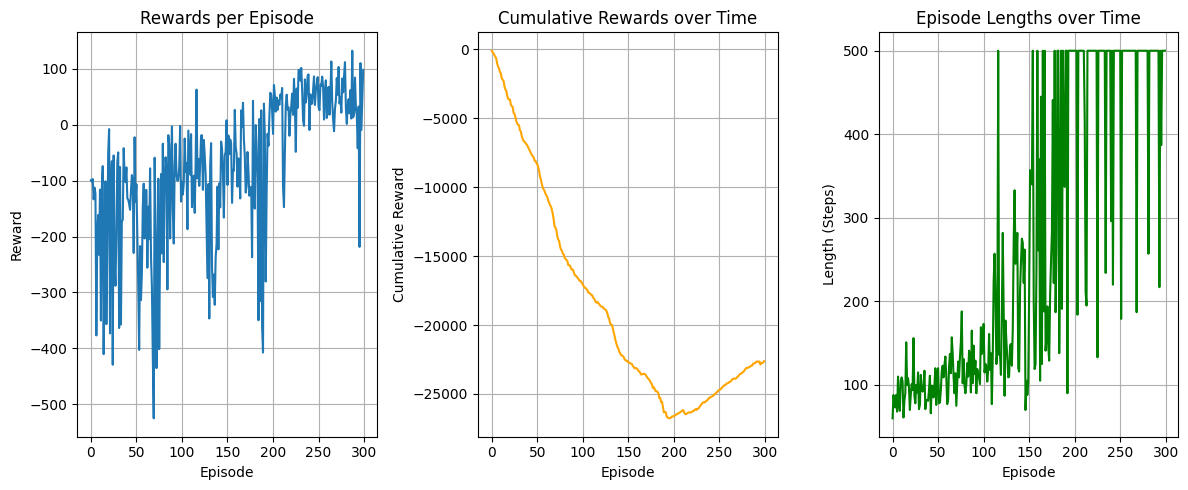

In [3]:
# Environment setup
env = gym.make('LunarLander-v2', render_mode="human")
state_size = env.observation_space.shape[0]  # 8 state variables for LunarLander
action_size = env.action_space.n  # 4 possible actions

# Hyperparameters
learning_rate = 0.005
gamma = 0.99  # Discount factor
batch_size = 64
max_episodes = 300
max_steps = 500
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
memory_size = 20000  # Replay buffer size
update_target_freq = 5  # Episodes between target model updates

# Replay buffer
memory = deque(maxlen=memory_size)

# Build the Deep Q-Network (DQN)
def build_model():
    model = Sequential([
        Dense(128, input_dim=state_size, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(action_size, activation='linear')  # Linear for Q-values
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')
    return model

model = build_model()
target_model = build_model()
target_model.set_weights(model.get_weights())

# Function to update target network
def update_target_model():
    target_model.set_weights(model.get_weights())

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Explore
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])  # Exploit


# Replay function for training
def replay():
    if len(memory) < batch_size:
        return

    mini_batch = random.sample(memory, batch_size)
    states, targets = [], []

    for state, action, reward, next_state, done in mini_batch:
        target = reward
        if not done:
            # Ensure correct shape for next_state
            next_state = np.reshape(next_state, [1, state_size])
            target += gamma * np.amax(target_model.predict(next_state, verbose=0)[0])

        # Ensure correct shape for state
        state = np.reshape(state, [1, state_size])
        target_q_values = model.predict(state, verbose=0)
        target_q_values[0][action] = target
        
        states.append(state[0])  # Add the flattened state
        targets.append(target_q_values[0])  # Add Q-values as target

    # Train the model with correctly formatted inputs
    model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)


# Training loop
# Additional metrics
cumulative_rewards = []  # Store cumulative rewards across all episodes
episode_lengths = []     # Store the length of each episode

# Training loop with metrics collection
rewards = []
for episode in range(max_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    steps = 0
    done = False

    for step in range(max_steps):
        action = select_action(state, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        done = bool(done) or bool(truncated)
        next_state = np.reshape(next_state, [1, state_size])

        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            print(f"Episode: {episode + 1}, Reward: {total_reward:.2f}, Steps: {steps}, Epsilon: {epsilon:.2f}")
            break

    rewards.append(total_reward)
    cumulative_rewards.append(sum(rewards))
    episode_lengths.append(steps)
    replay()

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if (episode + 1) % update_target_freq == 0:
        update_target_model()

# Plot cumulative rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards, label='Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.grid(True)

# Plot cumulative rewards
plt.subplot(1, 3, 2)
plt.plot(cumulative_rewards, label='Cumulative Rewards', color='orange')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards over Time')
plt.grid(True)

# Plot episode lengths
plt.subplot(1, 3, 3)
plt.plot(episode_lengths, label='Episode Lengths', color='green')
plt.xlabel('Episode')
plt.ylabel('Length (Steps)')
plt.title('Episode Lengths over Time')
plt.grid(True)

# Display plots
plt.tight_layout()
plt.show()

# Environment cleanup
#env.close()

In [ ]:
# Save the model
model.save('dqn_model.h5')
target_model.save('dqn_target_model.h5')

# Save the replay buffer
with open('replay_buffer.pkl', 'wb') as f:
    pickle.dump(memory, f)

In [9]:
from matplotlib.animation import FuncAnimation

# Function to visualize one episode
def show_one_episode(model, n_max_steps=200, seed=42):
    def policy(obs):
        obs = np.reshape(obs, [1, state_size])  # Ensure correct input shape
        q_values = model.predict(obs, verbose=0)
        return np.argmax(q_values[0])  # Greedy action

    frames = []
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

# Function to animate frames
def plot_animation(frames):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_data(frame)
        return [img]

    ani = FuncAnimation(fig, update, frames=frames, blit=True, interval=50)
    plt.close(fig)
    return ani

# Visualize one episode
animation = show_one_episode(model)
plt.rc('animation', html='jshtml')  # Enable animation rendering in Jupyter
animation